In [2]:
import numpy as np # linear algebra
#import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import matplotlib.pyplot as plt
import matplotlib
from torch.utils.data import DataLoader, Dataset, ConcatDataset
import torch.nn as nn
import copy
import torch
from torchvision import transforms
from torch.optim import lr_scheduler
import os
import math
import numpy as np
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
from sklearn.preprocessing import MinMaxScaler, QuantileTransformer
from skimage import io
import umap.umap_ as umap
import torchvision.transforms as T
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [11]:
#Variables
path = './data/'
BATCH_SIZE = 10
EPOCHS = 1000
applier = T.RandomApply(transforms=[T.RandomVerticalFlip(p=0.5),
                                    T.RandomHorizontalFlip(p=0.5)
                                    ,T.RandomRotation(20),
                                    T.RandomRotation(75)]
                        ,p=0.5)
width_img = 60
height_img = 60
INPUT_SIZE = width_img*height_img
HIDDEN_SIZE1 = 4000
HIDDEN_SIZE2 = 100
OUTPUT_SIZE = 1
learning_rate = 0.0001
loss_fn = nn.BCEWithLogitsLoss()
#resize = None
resize = transforms.Resize(size = (width_img,height_img))

In [12]:
def read_image(path) :
    """Read content of data folders, and store inside a dictionary object:
    - 'img_dir' key contains paths of images
    - 'label' key contains the level of difficulty to determine if the image is fake or not
    - 'label_bin' key contains the true value of reality (fake/real) of every picture.  
    Input: path
    Output: Dict(img_dir, label, label_bin) and mapping
    """
    img_dict = {"img_dir" : [], "label" : [], 'label_bin':[]}
    for root, dirs, files in os.walk(path):
        for img in files:
            img_dict["img_dir"].append(os.path.join(root, img))
            img_dict["label"].append(img[:4])
            if img[:4] != 'real':
                img_dict["label_bin"].append(1.0)
            else:
                img_dict["label_bin"].append(0.0)
    label2int = {}
    set_of_label = img_dict["label"]
    for label in set_of_label:
        if label not in label2int:
            label2int[label]= len(label2int)
    img_dict["label"] = [label2int[label] for label in img_dict["label"]]
    return img_dict, label2int

# Data set class
class FaceDataset(Dataset):

    def __init__(self, image_dir, label_bin,
                 label, transform = None):
        
        """Function to load images into Tensor
            Args: 
                - image_dir : directory of images
                - Return : a dictonary with images and labels
        """
        self.img_dir = image_dir
        self.label_bin = label_bin
        self.label = label
        self.transform = transform
        
    def __len__(self) :
        return len(self.label_bin)


    def __getitem__(self, index) :
        path = torch.from_numpy(io.imread(self.img_dir[index],
                                         as_gray=False).astype(np.float32)).permute(2,0,1)
        label_bin = torch.tensor(self.label_bin[index],dtype=torch.float32)
        label = torch.tensor(self.label[index],dtype=torch.float32)
        if self.transform:
            img = path * 255.0
            img = torch.clip(img, 0.0, 255.0)
            img = img.type(torch.uint8)
            path = self.transform(img)
            path = path.type(torch.float32)
        return path, label_bin, label

In [13]:
def plot_embeddings(X, y, title):
    
    y = y.astype(int)
    X = QuantileTransformer().fit_transform(X)
    
    plt.figure(figsize = (10,10))
    for i in range(X.shape[0]):        
        plt.text(X[i, 0],
                 X[i, 1],
                 str(y[i]),
                 color=plt.cm.Dark2(y[i]),
                 fontdict={"weight": "bold", "size": 9})
    plt.xticks([]), plt.yticks([])
    plt.title('t-SNE - ' + title, fontsize=16)
    plt.show()
    
    return

def plot_history(history, figsize=(8,6), 
                 plot={"Accuracy":['val_accuracy'], 'Loss':['loss', 'val_loss']},
                 save_as='auto'):
    """
    Show history
    args:
        history: history
        figsize: fig size
        plot: list of data to plot : {<title>:[<metrics>,...], ...}
    """
    fig_id=0
    for title,curves in plot.items():
        plt.figure(figsize=figsize)
        plt.title(title)
        plt.ylabel(title)
        plt.xlabel('Epoch')
        for c in curves:
            plt.plot(history[c])
        plt.legend(curves, loc='upper right')
        plt.show()
        
def plot_images(x,y=None, indices='all', columns=12, x_size=1, y_size=1,
                colorbar=False, y_pred=None, cm="gray", norm=None, y_padding=0.35, spines_alpha=1,
                fontsize=20, interpolation='lanczos'):
    """
    Show some images in a grid, with legends
    args:
        x             : images - Shapes must be (-1,lx,ly) (-1,lx,ly,1) or (-1,lx,ly,3)
        y             : real classes or labels or None (None)
        indices       : indices of images to show or 'all' for all ('all')
        columns       : number of columns (12)
        x_size,y_size : figure size (1), (1)
        colorbar      : show colorbar (False)
        y_pred        : predicted classes (None)
        cm            : Matplotlib color map (binary)
        norm          : Matplotlib imshow normalization (None)
        y_padding     : Padding / rows (0.35)
        spines_alpha  : Spines alpha (1.)
        font_size     : Font size in px (20)
        save_as       : Filename to use if save figs is enable ('auto')
    returns: 
        nothing
    """
    if indices=='all': indices=range(len(x))
    if norm and len(norm) == 2: norm = matplotlib.colors.Normalize(vmin=norm[0], vmax=norm[1])
    draw_labels = (y is not None)
    draw_pred   = (y_pred is not None)
    rows        = math.ceil(len(indices)/columns)
    fig=plt.figure(figsize=(columns*x_size, rows*(y_size+y_padding)))
    n=1
    for i in indices:
        axs=fig.add_subplot(rows, columns, n)
        n+=1
        # ---- Shape is (lx,ly)
        if len(x[i].shape)==2:
            xx=x[i]
        # ---- Shape is (lx,ly,n)
        if len(x[i].shape)==3:
            (lx,ly,lz)=x[i].shape
            if lz==1: 
                xx=x[i].reshape(lx,ly)
            else:
                xx=x[i]
        img=axs.imshow(xx,   cmap = cm, norm=norm,)
#         img=axs.imshow(xx,   cmap = cm, interpolation=interpolation)
        axs.set_yticks([])
        axs.set_xticks([])
        if draw_labels and not draw_pred:
            axs.set_xlabel(y[i],fontsize=fontsize)
        if draw_labels and draw_pred:
            if y[i]!=y_pred[i]:
                axs.set_xlabel(f'{y_pred[i]} ({y[i]})',fontsize=fontsize)
                axs.xaxis.label.set_color('red')
            else:
                axs.set_xlabel(y[i],fontsize=fontsize)
        if colorbar:
            fig.colorbar(img,orientation="vertical", shrink=0.65)
    fig.tight_layout(pad=0.8)
    plt.show()


def plot_confusion_matrix(y_true,y_pred,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True,
                          figsize=(10, 8),
                          digit_format='{:0.2f}'):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    cm = confusion_matrix( y_true,y_pred, normalize=None, labels=target_names)
    
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=90)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, digit_format.format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [14]:
class EarlyStopping:
    """Define an Early Stopping for our models"""
    def __init__(self, patience=15):
        
        self.patience = patience #number of epochs without loss decrease to tolerate before stopping
        self.counter = 0 # epochs without loss decrease
        self.min_validation_loss = np.inf #initialise min_loss to infinite


    def stop_train(self, validation_loss):
        """update min_validation_loss if current valid_loss < min_validation_loss,
        reset counter to 0 and save model parameters
        else increment counter value by 1, stop training if counter >= patience
        Args:
            validation_loss: current validation loss
        Returns:
            bool: Stops the train or not
        """
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
            
        elif validation_loss > (self.min_validation_loss):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False


In [15]:
#Load data
all_data,_ = read_image(path)
label, label_bin, img_dir = all_data["label"],  all_data["label_bin"],all_data["img_dir"]
# Divide 80% for train
label_tr, label_test, label_bin_tr, label_bin_test, img_dir_tr, img_dir_test = train_test_split(label,
                                                                                                label_bin,
                                                                                                img_dir, 
                                                                                                test_size=0.2,
                                                                                                random_state=0)

# Use 10% for validation and 10% for test
label_val, label_test, label_bin_val, label_bin_test, img_dir_val, img_dir_test= train_test_split(label_test,
                                                                  label_bin_test,
                                                                  img_dir_test, 
                                                                  test_size=0.5,
                                                                  random_state=0)

In [16]:
# Load with Dataset class
train_dataset = FaceDataset(img_dir_tr,label_bin_tr,label_tr)
valid_dataset = FaceDataset(img_dir_val,label_bin_val, label_val)
test_dataset = FaceDataset(img_dir_test,label_bin_test, label_test)

#Build Dataloader
train_data_loader = DataLoader(train_dataset, 
                               batch_size=BATCH_SIZE, 
                               shuffle=True, 
                               drop_last=True )
valid_data_loader = DataLoader(valid_dataset, 
                               batch_size=BATCH_SIZE, 
                               shuffle=True, 
                               drop_last=True)
test_data_loader = DataLoader(test_dataset, 
                              batch_size=BATCH_SIZE, 
                              shuffle=True, 
                               drop_last=True)

len(train_dataset)

1632

In [17]:
def accuracy_fn(y_true, y_pred):
    """
        Compute accuracy from two tensors
        Args: y_true : Tensor
              y_pred : Tensor
        Return: Float
    """
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100 
    return acc


def eval_binary_classifier(model, eval_dataloader, loss_fn, resize = None,mlp = False):
    sigmoid = nn.Sigmoid()
    model.eval() 
    #model.to(device)
    if resize:
        transform = resize
    # In evaluation phase, we don't need to compute gradients (for memory efficiency)
    with torch.no_grad():
        # initialize the total and correct number of labels to compute the accuracy
        loss, accuracy = 0, 0
        # Iterate over the dataset using the dataloader
        for images, labels,_ in eval_dataloader:
            #images = torch.tensor(images, dtype=float)
            if resize:
                images = transform(images)/255
            #labels.to(device)
            if mlp:
                
                images = images.reshape(images.shape[0], -1)
            #images.to(device)
            #print(images.shape)
            # Get the predicted labels
            y_predicted = model(images.to(device))

            if mlp:
                l = loss_fn(y_predicted, labels.unsqueeze(1).to(device))
            else:
                l = loss_fn(y_predicted, labels.view(-1, 1).to(device))
            loss += l.item()
            accuracy += accuracy_fn(labels.to(device), torch.round(sigmoid(y_predicted)).squeeze(1))
        accuracy = accuracy/len(eval_dataloader)

    return loss, accuracy

def train_val_binary_classifier(model, train_dataloader, 
                                valid_dataloader, num_epochs, 
                                loss_fn, learning_rate, resize=None,verbose=True,
                                file_name='model_parameters.pt',
                                mlp = False):

    # Make a copy of the model (avoid changing the model outside this function)
    model_tr = copy.deepcopy(model)
    model_tr = model_tr.to(device)
    
    # Set the model in 'training' mode (ensures all parameters' gradients are computed - it's like setting 'requires_grad=True' for all parameters)
    model_tr.train()
    #optimizer = #torch.optim.Adam(model_tr.parameters(), lr=learning_rate)
    optimizer =torch.optim.SGD(model_tr.parameters(), lr=learning_rate,
                               momentum=0.9)
    scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
    # Initialize a list to record the training loss over epochs
    loss_all_epochs = []
    valid_loss, valid_acc = [], []
    if resize:
        transform = resize
    
    #Initialize earlystopping
    early_stopping = EarlyStopping()
    # Training loop

    for epoch in range(num_epochs):
        # Initialize the training loss for the current epoch
        loss_current_epoch = 0
        
        # Iterate over batches using the dataloader
        for batch_index, (images, labels,_) in enumerate(train_dataloader):
            if resize:
                images = transform(images)/255
            if mlp:
                images = images.reshape(images.shape[0], -1)
            #print(images.shape)
            y_pred = model_tr(images.to(device))
            if mlp:
                l = loss_fn(y_pred, labels.unsqueeze(1).to(device))
            else:
                l = loss_fn(y_pred, labels.view(-1, 1).to(device))
            
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            loss_current_epoch +=  l.item()


        scheduler.step()
        loss_all_epochs.append(loss_current_epoch)
        val_loss, accuracy = eval_binary_classifier(model_tr, 
                                                 valid_dataloader,
                                                 loss_fn, resize=resize, mlp=mlp)
        valid_loss.append(val_loss)
        valid_acc.append(accuracy)

        if verbose:
            print(f"\nEpoch [{epoch+1}/{num_epochs}]"
                  f"\nTrain loss: {loss_current_epoch:.5f} | "
                  f"Valid loss: {val_loss:.5f} | Valid acc: {accuracy:.2f}%\n")
            
        if epoch >0 and val_loss < min(valid_loss[:-1]):
            #save parameters if val_loss decreases 
            
            torch.save(model_tr.state_dict(), file_name)
            print('Saved new state.')
            
        if early_stopping.stop_train(val_loss): 
            #stop training if early stopping triggered 
            print('Early stopping activated, stop training at epoch #{}.'.format(epoch+1))
            break
            

            
        
    return model_tr, {'loss': loss_all_epochs,'val_loss': valid_loss, 'val_accuracy': valid_acc}

In [18]:
class MLPClassif(nn.Module):
    """Our FeedForward Network"""
    def __init__(self, input_size, hidden_size1,hidden_size2, output_size):
        super(MLPClassif, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size1)
        self.layer2 = nn.Linear(hidden_size1, hidden_size1)
        self.hidden3 = nn.Linear(hidden_size1, hidden_size2)
        self.hidden4 = nn.Linear(hidden_size2, hidden_size2)
        self.out_layer = nn.Linear(hidden_size2, output_size)
        self.relu = nn.ReLU()
        self.batchnorm = nn.BatchNorm1d(hidden_size1)
        self.batchnorm2 = nn.BatchNorm1d(hidden_size2)
        self.dropout1 = nn.Dropout(p=0.25)
        self.dropout2 = nn.Dropout(p=0.25)
        
    
    def forward(self, x):

        #sigmoid = nn.Sigmoid()
        x = self.layer1(x)
        x = self.relu(x)
        #x = self.dropout1(x)
        x = self.batchnorm(x)
        x = self.layer2(x)
        x = self.relu(x)
        #x = self.dropout2(x)
        x = self.batchnorm(x)
        x = self.hidden3(x)
        x = self.relu(x)
        #x = dropout(x)
        x = self.hidden4(x)
        x = self.relu(x)
        x = self.batchnorm2(x)
        #x = dropout(x)
        out = self.out_layer(x)
        return out

- Base Model
- MLP with **4000** neurons in the first two layers and **100** in the 2 last layer
- Original dataset without data augmentation

In [19]:
# Initialize MLP and train it

model = MLPClassif(INPUT_SIZE, HIDDEN_SIZE1, HIDDEN_SIZE2, OUTPUT_SIZE)

def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight.data)
        m.bias.data.fill_(0.01)
        

#torch.manual_seed(0)
model.apply(init_weights)
mlp_transform = T.Compose([T.Grayscale(), resize])

In [86]:
model = model.to(device)
print('Train on GPU: '+ str(next(model.parameters()).is_cuda))
model_mlp, mlp_history = train_val_binary_classifier(model, 
                                                     train_data_loader,
                                                     valid_data_loader,
                                                     EPOCHS,loss_fn,
                                                     learning_rate, 
                                                     verbose=True,
                                                     resize=mlp_transform,
                                                     file_name='mlp_parameters.pt',
                                                     mlp = True)

Train on GPU: False

Epoch [1/1000]
Train loss: 123.98467 | Valid loss: 14.53824 | Valid acc: 53.50%


Epoch [2/1000]
Train loss: 110.86987 | Valid loss: 14.32808 | Valid acc: 58.50%

Saved new state.

Epoch [3/1000]
Train loss: 97.90613 | Valid loss: 14.53102 | Valid acc: 61.50%


Epoch [4/1000]
Train loss: 88.21936 | Valid loss: 14.24851 | Valid acc: 58.50%

Saved new state.

Epoch [5/1000]
Train loss: 80.10042 | Valid loss: 15.31675 | Valid acc: 60.50%


Epoch [6/1000]
Train loss: 70.34368 | Valid loss: 15.02133 | Valid acc: 58.50%


Epoch [7/1000]
Train loss: 62.27069 | Valid loss: 15.39389 | Valid acc: 57.00%


Epoch [8/1000]
Train loss: 56.25329 | Valid loss: 16.07978 | Valid acc: 59.50%


Epoch [9/1000]
Train loss: 50.84926 | Valid loss: 15.95402 | Valid acc: 54.50%


Epoch [10/1000]
Train loss: 47.83503 | Valid loss: 15.67773 | Valid acc: 59.00%


Epoch [11/1000]
Train loss: 42.63096 | Valid loss: 15.96241 | Valid acc: 57.50%


Epoch [12/1000]
Train loss: 39.32559 | Valid loss:

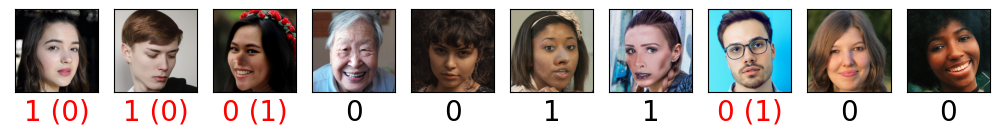

In [87]:
#Small overview of results

def test_overview(model, dataloader, resize = None):
    """Display an overview of the results over the first batch of the dataloader 

    Args:
        model : Trained model
        dataloader: Dataloader
        resize (_type_, optional): Transformation to apply to all images of the batch.
        Defaults to None.
    """
    sigmoid = nn.Sigmoid()
    x_test, y_test,_ = next(iter(dataloader))
    if resize:
        transform = mlp_transform
        x_t = transform(x_test)
    y_pred = model(x_t.squeeze().view(x_t.shape[0],-1).to(device)).cpu()
    y_test = y_test.numpy().astype(int)
    y_pred = torch.round(sigmoid(y_pred)).squeeze(1).detach().numpy().astype(int)
    x_test = x_test.permute(0,2,3,1).numpy()
    plot_images(x_test/255, y_test, range(0,10), columns=12, x_size=1, y_size=1, y_pred=y_pred)
test_overview(model_mlp, test_data_loader, resize=resize)

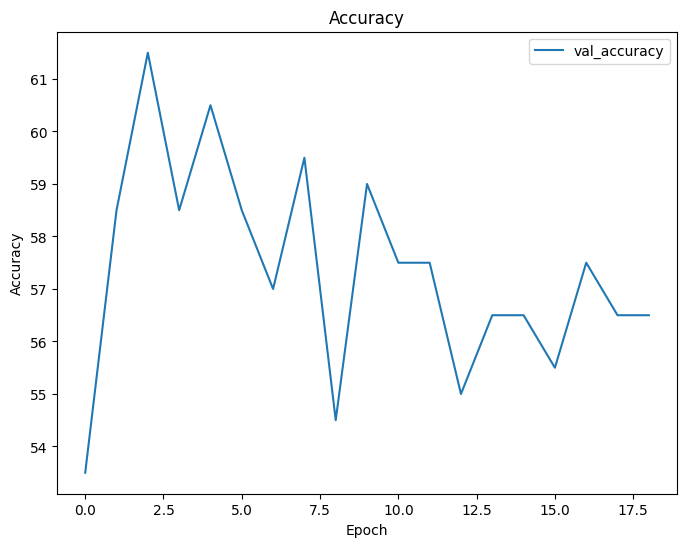

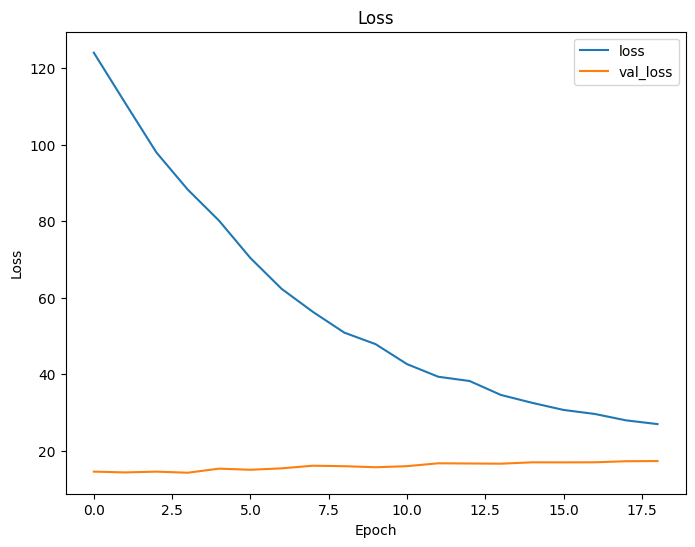

In [88]:
#Plot validation accuracy and loss curves
plot_history(mlp_history)

In [89]:
# Evaluation of the MLP on the test dataloader
print("Accuracy: "+ str(eval_binary_classifier(model_mlp, test_data_loader, loss_fn=loss_fn, 
                       resize = mlp_transform, mlp=True)[1]))

Accuracy: 62.0


- The first model with MLP has bad performance. It does not perform than random selection

## MLP with Data Augmentation

- We will create a dataset by applying a sequence of transformation: HorizontalFlip, Vertical Flip
- Then, we will use ConcatDataset function to add it to the original dataset

In [20]:
aug_dataset = FaceDataset(img_dir_tr,label_bin_tr,label_tr,
                            transform=applier)
train_dataset = ConcatDataset([train_dataset, aug_dataset])
train_data_loader = DataLoader(train_dataset, 
                               batch_size=BATCH_SIZE, 
                               shuffle=True, 
                               drop_last=True )

In [93]:
# 
model = MLPClassif(INPUT_SIZE, HIDDEN_SIZE1, HIDDEN_SIZE2, OUTPUT_SIZE)
model.apply(init_weights)

MLPClassif(
  (layer1): Linear(in_features=3600, out_features=4000, bias=True)
  (layer2): Linear(in_features=4000, out_features=4000, bias=True)
  (hidden3): Linear(in_features=4000, out_features=100, bias=True)
  (hidden4): Linear(in_features=100, out_features=100, bias=True)
  (out_layer): Linear(in_features=100, out_features=1, bias=True)
  (relu): ReLU()
  (batchnorm): BatchNorm1d(4000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.25, inplace=False)
)

In [94]:
model = model.to(device)
learning_rate = 0.001
print('Train on GPU: '+ str(next(model.parameters()).is_cuda))
model_mlp2, mlp_history2 = train_val_binary_classifier(model, 
                                                     train_data_loader,
                                                     valid_data_loader,
                                                     EPOCHS,loss_fn,
                                                     learning_rate, 
                                                     verbose=True,
                                                     resize=mlp_transform,
                                                     file_name='mlp_parameters.pt',
                                                     mlp = True)

Train on GPU: False

Epoch [1/1000]
Train loss: 246.64318 | Valid loss: 14.41833 | Valid acc: 52.50%


Epoch [2/1000]
Train loss: 241.56408 | Valid loss: 15.29010 | Valid acc: 48.50%


Epoch [3/1000]
Train loss: 226.19561 | Valid loss: 14.25561 | Valid acc: 53.50%

Saved new state.

Epoch [4/1000]
Train loss: 213.82939 | Valid loss: 14.34607 | Valid acc: 53.50%


Epoch [5/1000]
Train loss: 208.18614 | Valid loss: 14.24003 | Valid acc: 54.00%

Saved new state.

Epoch [6/1000]
Train loss: 203.25556 | Valid loss: 14.37075 | Valid acc: 55.50%


Epoch [7/1000]
Train loss: 197.95782 | Valid loss: 14.50192 | Valid acc: 54.50%


Epoch [8/1000]
Train loss: 193.11641 | Valid loss: 14.39251 | Valid acc: 55.50%


Epoch [9/1000]
Train loss: 187.58123 | Valid loss: 14.78674 | Valid acc: 54.00%


Epoch [10/1000]
Train loss: 184.92604 | Valid loss: 14.64354 | Valid acc: 56.00%


Epoch [11/1000]
Train loss: 182.52922 | Valid loss: 14.69804 | Valid acc: 53.50%


Epoch [12/1000]
Train loss: 177.94953 | V

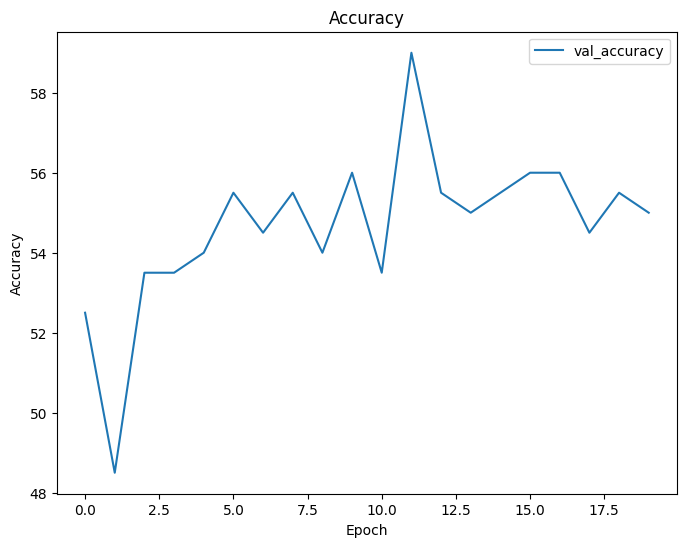

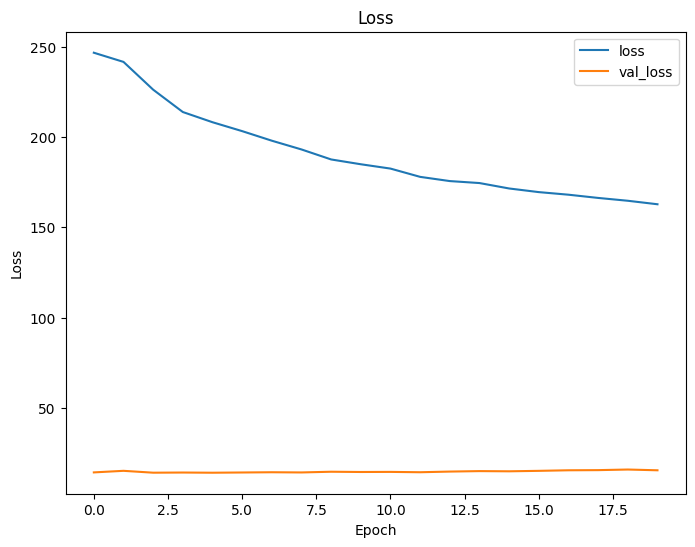

In [95]:
plot_history(mlp_history2)

# CNN

In [96]:
class CNN(nn.Module):
    def __init__(self, num_channels1=16, num_channels2=32,num_channels3 = 64, num_classes=1):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(nn.Conv2d(in_channels=1, out_channels= num_channels1, 
                                                   kernel_size=5, padding=2),
                           nn.ReLU(),
                           nn.BatchNorm2d(num_channels1, affine=False),
                           nn.MaxPool2d(kernel_size=2))

        
        self.layer2 = nn.Sequential(nn.Conv2d(num_channels1, num_channels2, 
                                                   kernel_size=5, padding=2),
                           nn.ReLU(),
                           nn.BatchNorm2d(num_channels2,affine=False),
                           nn.MaxPool2d(kernel_size=2))
        self.layer3 = nn.Sequential(nn.Conv2d(num_channels2, num_channels3, 
                                                   kernel_size=5, padding=2),
                           nn.ReLU(),
                           nn.BatchNorm2d(num_channels3,affine=False),
                           nn.MaxPool2d(kernel_size=2))
        self.dropout = nn.Dropout2d(p=0.1)
        self.fc = nn.Linear(3136, num_classes)

    def forward(self, x):
        #print(x.shape)
        x = self.layer1(x)
        x=self.dropout(x)
        x = self.layer2(x)
        x = self.dropout(x)
        x=self.layer3(x)
        #out = self.fc(x.view(-1, 32*7*7))
        x= x.reshape(x.size(0), -1)
        #print(x.shape)
        out = self.fc(x)
        return out

## CNN With Original Data

In [ ]:
learning_rate = 0.01
# Initialize CNN and train it
model_cnn = CNN()
model_cnn.apply(init_weights)
model_cnn.to(device)
print('Train on GPU: '+ str(next(model_cnn.parameters()).is_cuda))

model_cnn, cnn_history= train_val_binary_classifier(model_cnn, 
                                                train_data_loader,valid_data_loader, 
                                                EPOCHS,loss_fn, learning_rate, verbose=True,
                                                file_name='cnn_parameters.pt',
                                                resize=resize)

Train on GPU: True

Epoch [1/1000]
Train loss: 2442.29201 | Valid loss: 99.71340 | Valid acc: 54.50%


Epoch [2/1000]
Train loss: 673.43759 | Valid loss: 16.07669 | Valid acc: 63.50%

Saved new state.

Epoch [3/1000]
Train loss: 477.31217 | Valid loss: 19.57642 | Valid acc: 49.50%


Epoch [4/1000]
Train loss: 352.88206 | Valid loss: 13.66788 | Valid acc: 62.00%

Saved new state.

Epoch [5/1000]
Train loss: 311.56857 | Valid loss: 16.38989 | Valid acc: 56.50%


Epoch [6/1000]
Train loss: 294.41113 | Valid loss: 29.38335 | Valid acc: 45.00%


Epoch [7/1000]
Train loss: 322.89276 | Valid loss: 13.62097 | Valid acc: 61.00%

Saved new state.

Epoch [8/1000]
Train loss: 325.09599 | Valid loss: 14.05781 | Valid acc: 59.00%


Epoch [9/1000]
Train loss: 276.81234 | Valid loss: 18.96380 | Valid acc: 58.50%


Epoch [10/1000]
Train loss: 290.51419 | Valid loss: 15.86308 | Valid acc: 58.50%


Epoch [11/1000]
Train loss: 256.27369 | Valid loss: 21.40293 | Valid acc: 55.50%


Epoch [12/1000]
Train lo

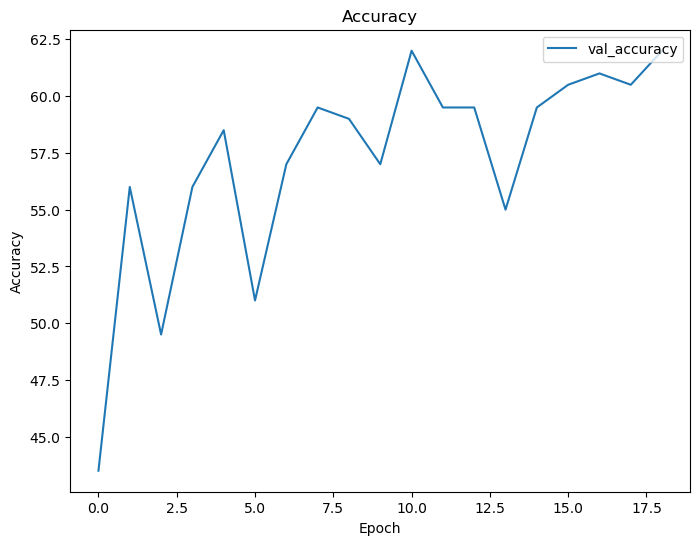

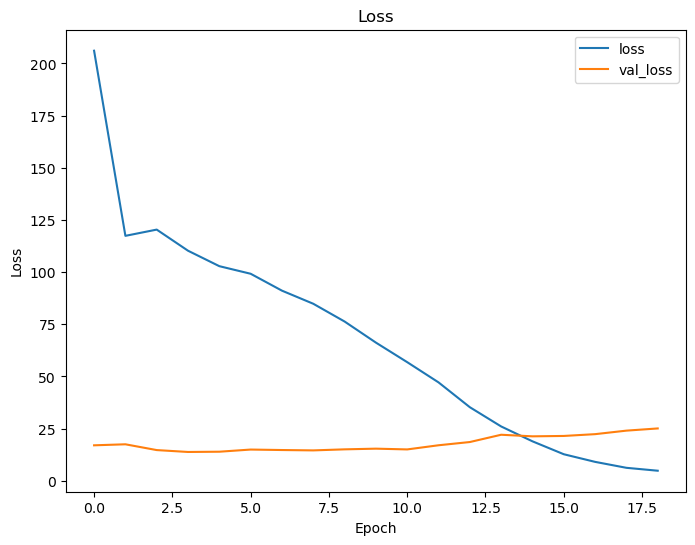

In [41]:
# Plot validation accuracy and loss curves
plot_history(cnn_history)

In [ ]:
# Evaluation of the CNN on the test dataloader
print("Accuracy: "+ str(eval_binary_classifier(model_cnn, test_data_loader, loss_fn=loss_fn, resize=resize))[1])

In [ ]:
def extract_TSNE_embeddings(model, data_loader, train_dataset, batch_size, len_layer,
                        transform=None, mlp = False):
    
    """Compute T-SNE Embeddings"""
    feature_maps_tot = torch.empty((len(train_dataset), len_layer), dtype=torch.float).to(device)
    labels_fm_tot = torch.empty(len(train_dataset), dtype=torch.float)

    model.eval()
    with torch.no_grad():
        for ib, (images, labels) in enumerate(data_loader):
            indices_b = torch.arange(ib*batch_size, (ib+1)*batch_size)
            labels_fm_tot[indices_b] = labels.float()
            if transform:
                images = transform(images)
            if mlp:
                images = images.reshape(images.shape[0], -1)
            out = model.layer1(images.to(device))
            out = model.layer2(out)
            feats_vec = out.reshape(batch_size, -1)
            feature_maps_tot[indices_b, :] = feats_vec

    feature_maps_tot = feature_maps_tot.cpu().numpy()
    labels_fm_tot = labels_fm_tot.numpy()
    print('Size of vectorized feature maps:', feature_maps_tot.shape)
    print('Size of the tensor storing labels:', labels_fm_tot.shape)
    feature_maps_TSNE = TSNE(n_components=2, init='pca').fit_transform(feature_maps_tot)
    print('Size TSNE embeddings (feature maps):', feature_maps_TSNE.shape)
    return feature_maps_TSNE, labels_fm_tot


tsne_embeddings_mlp = extract_TSNE_embeddings(model_mlp, train_data_loader,
                                       train_dataset, BATCH_SIZE, len_layer = HIDDEN_SIZE, transform = resize,
                                       mlp = True
                                       )
plot_embeddings(tsne_embeddings_mlp[0], tsne_embeddings_mlp[1], "MLP")

In [ ]:
tsne_embeddings_cnn = extract_TSNE_embeddings(model_cnn, train_data_loader,
                                       train_dataset, BATCH_SIZE, len_layer = 7200, transform = resize,
                                       
                                       )
plot_embeddings(tsne_embeddings_cnn[0], tsne_embeddings_cnn[1], 'CNN')

## CNN With Data Augmentation

In [98]:
learning_rate = 0.01
# Initialize CNN and train it
model_cnn = CNN()
model_cnn.apply(init_weights)
model_cnn.to(device)
print('Train on GPU: '+ str(next(model_cnn.parameters()).is_cuda))

model_cnn, cnn_history= train_val_binary_classifier(model_cnn, 
                                                train_data_loader,valid_data_loader, 
                                                EPOCHS,loss_fn, learning_rate, verbose=True,
                                                file_name='cnn_parameters.pt',
                                                resize=mlp_transform)

Train on GPU: False

Epoch [1/1000]
Train loss: 2444.51233 | Valid loss: 111.73366 | Valid acc: 47.00%


Epoch [2/1000]
Train loss: 775.58795 | Valid loss: 28.42642 | Valid acc: 52.50%

Saved new state.

Epoch [3/1000]
Train loss: 481.23439 | Valid loss: 15.89140 | Valid acc: 54.50%

Saved new state.

Epoch [4/1000]
Train loss: 339.41041 | Valid loss: 14.88186 | Valid acc: 59.50%

Saved new state.

Epoch [5/1000]
Train loss: 289.26728 | Valid loss: 14.30910 | Valid acc: 56.50%

Saved new state.

Epoch [6/1000]
Train loss: 244.89292 | Valid loss: 14.05594 | Valid acc: 54.50%

Saved new state.

Epoch [7/1000]
Train loss: 252.37294 | Valid loss: 19.35220 | Valid acc: 52.00%


Epoch [8/1000]
Train loss: 258.55933 | Valid loss: 13.63988 | Valid acc: 62.00%

Saved new state.

Epoch [9/1000]
Train loss: 233.60960 | Valid loss: 14.88629 | Valid acc: 59.00%


Epoch [10/1000]
Train loss: 238.77304 | Valid loss: 14.75290 | Valid acc: 60.00%


Epoch [11/1000]
Train loss: 234.32295 | Valid loss: 13

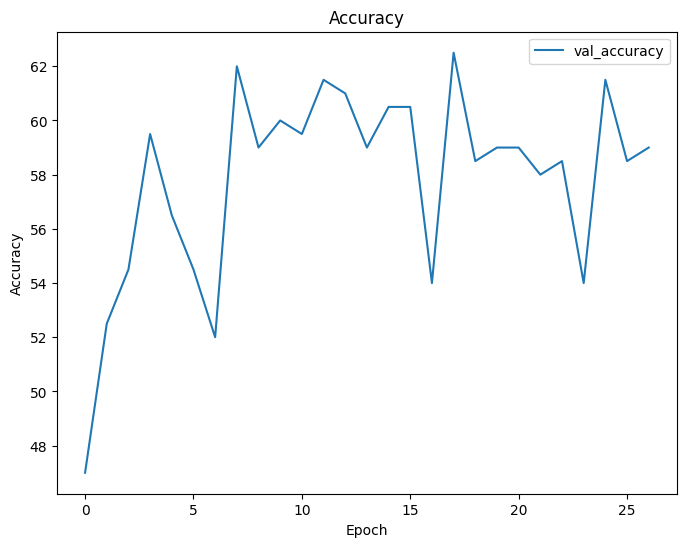

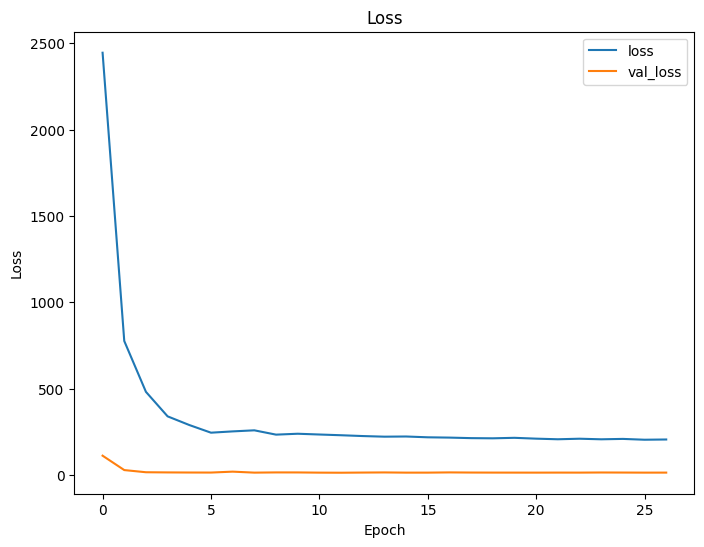

In [101]:
plot_history(cnn_history)

In [100]:
print("Accuracy: "+ str(eval_binary_classifier(model_cnn, test_data_loader, 
                         loss_fn=loss_fn, resize=mlp_transform))[1])

Accuracy: 1


# Transfert learning with MobilenetV2

In [21]:
import torchvision.models as models

def build_model(name, fine_tune=True, num_classes=1):

    assert name in ("mobilenetv2", "efficientnet_b0")

    print('[INFO]: Loading pre-trained weights')
    if name =="mobilenetv2":
        model = models.mobilenet_v2(weights="DEFAULT")
    else:

        model = models.efficientnet_b0(weights="EfficientNet_B0_Weights.DEFAULT")
    if fine_tune:
        print('[INFO]: Fine-tuning all layers...')
        for params in model.parameters():
            params.requires_grad = True
    elif not fine_tune:
        print('[INFO]: Freezing hidden layers...')
        for params in model.parameters():
            params.requires_grad = False
    # Change the final classification head.
    model.classifier[1] = nn.Linear(in_features=1280, out_features=num_classes)
    return model

In [22]:
model = build_model(name="mobilenetv2", fine_tune=True, num_classes=1)
mobilenet_transform = T.Compose([T.Resize(size = [224,224]),
                 T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])


[INFO]: Loading pre-trained weights
[INFO]: Fine-tuning all layers...


In [24]:
learning_rate = 0.001
mobilenet, mobilenet_history= train_val_binary_classifier(model, 
                                                train_data_loader,valid_data_loader, 
                                                EPOCHS,loss_fn, learning_rate, verbose=True,
                                                file_name='cnn_parameters.pt',
                                                resize=mobilenet_transform)


Epoch [1/1000]
Train loss: 223.17015 | Valid loss: 13.40455 | Valid acc: 56.00%


Epoch [2/1000]
Train loss: 224.23461 | Valid loss: 13.86452 | Valid acc: 47.50%


Epoch [3/1000]
Train loss: 219.67002 | Valid loss: 13.48293 | Valid acc: 60.50%


Epoch [4/1000]
Train loss: 218.48010 | Valid loss: 14.02119 | Valid acc: 48.50%


Epoch [5/1000]
Train loss: 216.58466 | Valid loss: 14.06775 | Valid acc: 47.00%


Epoch [6/1000]
Train loss: 211.06694 | Valid loss: 13.84306 | Valid acc: 51.00%


Epoch [7/1000]
Train loss: 209.92027 | Valid loss: 12.82240 | Valid acc: 68.00%

Saved new state.

Epoch [8/1000]
Train loss: 204.54264 | Valid loss: 12.66768 | Valid acc: 66.50%

Saved new state.

Epoch [9/1000]
Train loss: 198.73541 | Valid loss: 13.15387 | Valid acc: 64.00%


Epoch [10/1000]
Train loss: 193.38146 | Valid loss: 13.15991 | Valid acc: 61.50%


Epoch [11/1000]
Train loss: 190.57624 | Valid loss: 12.15356 | Valid acc: 65.50%

Saved new state.

Epoch [12/1000]
Train loss: 188.21674 | Vali